In [1]:
import django, os, sys, time, resource, re, gc, shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from django.db.models import Count, Avg, F, Sum
import math

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from utils.utils import ars

qid = 1558
q = Query.objects.get(pk=qid)


In [2]:

p = Project.objects.get(title="NETs")
pdocs = Doc.objects.filter(query__project=p)

techs = Technology.objects.filter(project=p).exclude(
    name__in=["Bioenergy","Geological Storage","Blue Carbon","Ethics & Morals"]
)
#techs = Technology.objects.filter(project=p)

print(techs)


trdocs = set(list(pdocs.filter(
    docownership__relevant=1,
    docownership__query__technology__in=techs
).values_list('UT',flat=True)))

ttdocs = set(list(Doc.objects.filter(
    technology__in=techs
).values_list('UT',flat=True)))

<QuerySet [<Technology: Soil Carbon Sequestration>, <Technology: Ocean Alkalinisation>, <Technology: Afforestation/reforestation>, <Technology: Biochar>, <Technology: Direct Air Capture>, <Technology: Ocean fertilisation>, <Technology: Enhanced Weathering>, <Technology: NETs - General>, <Technology: BECCS>]>


In [3]:
print(len(trdocs))
print(len(ttdocs))

allreldocs =  Doc.objects.filter(
    UT__in=trdocs.union(ttdocs)
)

print(allreldocs.count())

print(allreldocs.order_by('PY').first().PY)
print(allreldocs.order_by('PY').first().title)

print(allreldocs.filter(PY__lt=1990).count())

1792
241
1968
1977
Production of synthetic methanol from air and water using controlled thermonuclear reactor power-I. technology and energy requirement
3


In [4]:
qdocs = Doc.objects.filter(query=q)
ard_ids = allreldocs.values_list('UT',flat=True)

badocs = qdocs.exclude(UT__in=ard_ids)

badocs[0].query.all()

<QuerySet [<Query: NETS_scopus_retry_y1>, <Query: ccs storage final both>, <Query: CCS storage>, <Query: ccs storage_both>, <Query: climate_all>, <Query: scopus_all>, <Query: CCS storage_scopus>, <Query: NETS_all_relevant>, <Query: NETS_scopus>]>

In [5]:
bypy = allreldocs.filter(
       PY__in=range(1989,2017)
).values('PY').annotate(
    n = Count('UT', distinct=True)
).order_by('PY')

for py in bypy:
    for ar in ars:
        if py['PY'] in ar['years']:
            py['ar'] = ar['n']
            py['ar_name'] = ar['name']

bypy = pd.DataFrame.from_dict(list(bypy))

bypy.head()

bypy.tail()


,PY,ar,ar_name,n
22,2012,5,AR5,160
23,2013,5,AR5,189
24,2014,6,AR6,196
25,2015,6,AR6,213
26,2016,6,AR6,261


In [6]:
doc_dict = []

ts = techs

#allreldocs = Doc.objects.filter(query=q)
pys = list(range(1988,2017))
for t in ts:
    for py in pys:
        ydocs = allreldocs.filter(PY=py)
        trdocs = set(list(ydocs.filter(
            query__technology=t,docownership__relevant=1,docownership__query__technology=t
        ).values_list('UT',flat=True)))
        ttdocs = set(list(ydocs.filter(
            technology=t
        ).values_list('UT',flat=True)))
        tdocs = Doc.objects.filter(
            UT__in=trdocs.union(ttdocs)
        )
        d = {
            'Technology': t.name,
            'PY': py,
            'n': tdocs.count()
        }
        doc_dict.append(d)
        
for py in doc_dict:
    for ar in ars:
        if py['PY'] in ar['years']:
            py['ar'] = ar['n']
            py['ar_name'] = ar['name']

        
df = pd.DataFrame.from_dict(doc_dict)

techorder = list(techs.order_by('-ndocs').values_list('name',flat=True))


df['Technology'] = pd.Categorical(
    df['Technology'],
    techorder
)

df['ysum'] = df['n'].groupby(df['PY']).transform('sum')

df['share'] = df['n'] / df['ysum'] * 100

In [7]:
df[(df['PY']<1990) & (df['n']>0)]
#df.head()

,PY,Technology,ar,ar_name,n,ysum,share
59,1989,Afforestation/reforestation,1,AR1,1,1,100.0


In [8]:

ardf = df[['Technology','ar_name','n']].groupby(['ar_name','Technology']).sum()

ardf = ardf.reset_index()

ardf['ysum'] = ardf['n'].groupby(ardf['ar_name']).transform('sum')

ardf['share'] = ardf['n'] / ardf['ysum'] * 100

/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


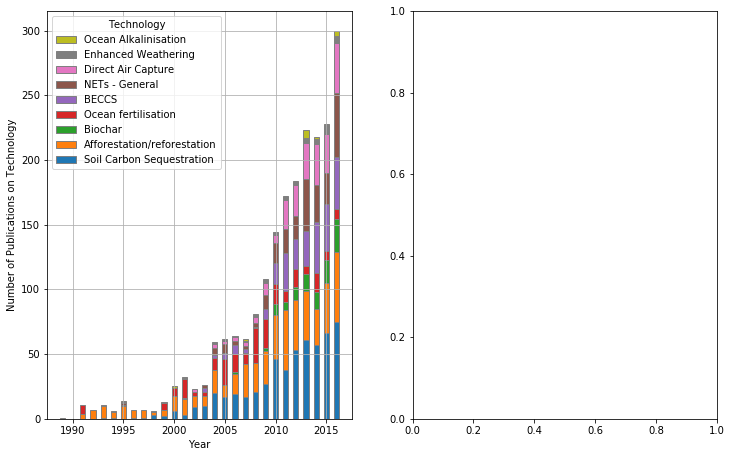

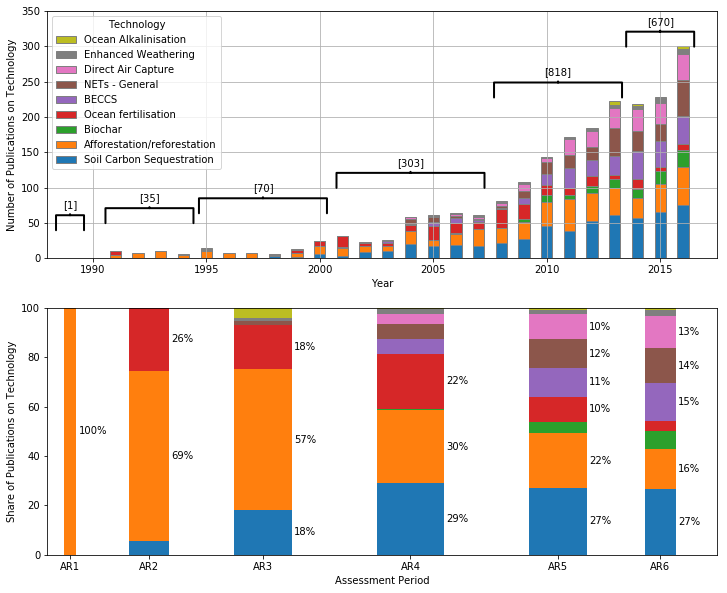

In [17]:

plt.rcParams["figure.figsize"] = [12,10]

fig, axs = plt.subplots(2,1)

ax = axs[0]

ax2 = axs[1]

pdf = df.pivot(
    index='PY',
    columns='Technology',
    values='n'
)


pdf.plot.bar(
    stacked=True, 
    ax=ax,
    legend=False,    
    lw=1,
    edgecolor='grey'#,
    #align='center'
)

handles, labels = ax.get_legend_handles_labels()

ax.xaxis.set_ticks([2,7,12,17,22,27])
ax.xaxis.set_ticklabels([1990,1995,2000,2005,2010,2015])

for tick in ax.get_xticklabels():
    tick.set_rotation(0)

ax.legend(handles[::-1], labels[::-1],title='Technology')

ax.set_xlabel('Year')
ax.set_ylabel('Number of Publications on Technology')

ax.grid(True)

ax.set_xlim(xmax=29.5)
ax.set_xlim(xmin=0)
ax.set_ylim(ymax=350)

mids = []

for name, group in bypy.groupby('ar_name'):
    count = "[{}]".format(group['n'].sum())
    miny = group['PY'].min() - 1988
    maxy = group['PY'].max() - 1988
    width = maxy-miny + 1.4
    mid = group['PY'].median() - 1988
    mids.append(mid)
    maxn = group['n'].max() + 60
    #ax.text(mid,maxn,count,ha="center")
    ar = group['ar'].max()
    ax.annotate(
        count,
        xy=(mid,maxn),
        xytext=(mid,maxn+10),
        ha="center",
        arrowprops=dict(arrowstyle='-[, widthB={}, lengthB=1.5'.format(width), lw=2.0)
    )
    art = ardf[ardf['ar_name']==name]
    b = 0
    h = 0
    for t in techorder:
        v = art[art['Technology']==t]
        if not v.empty:
            v = float(v['share'])
            ax2.bar(
                mid,v,bottom=b,align="center",
                width=width*0.4,color=handles[h].patches[0]._facecolor
            )        
            if v > 10:
                ax2.text(mid+width*0.2+0.1,b+v*0.5,"{}%".format(round(v)),va="center")
            b+=v
        h+=1

ax = ax2

for tick in ax.get_xticklabels():
    tick.set_rotation(0)


legend = ax.legend()#handles[::-1], labels[::-1],title='Technology')
#legend.remove()

ax.xaxis.set_ticks(mids)
ax.xaxis.set_ticklabels(["AR1","AR2","AR3","AR4","AR5","AR6"])

ax.set_xlabel('Assessment Period')
ax.set_ylabel('Share of Publications on Technology')

ax.set_xlim(xmax=29.5)
ax.set_xlim(xmin=0)

plt.savefig('plots/general/all_ars.png',bbox_inches='tight') 

plt.show()




In [10]:
ardf.groupby('ar_name').sum()

,n,ysum,share
ar_name,,,
AR1,1,9,100.0
AR2,35,315,100.0
AR3,72,648,100.0
AR4,328,2952,100.0
AR5,912,8208,100.0
AR6,746,6714,100.0


In [11]:
import matplotlib.patches as mpatches

pdf = bypy.set_index('PY')
colors = {
    0: '#8dd3c7', 
    1: '#d53e4f', 
    2: '#fc8d59', 
    3: '#fee08b', 
    4: '#e6f598', 
    5: '#99d594', 
    6: '#3288bd'
}

#d53e4f
#fc8d59
#fee08b
#e6f598
#99d594
#3288bd

#pdf['n'].plot.bar(color=[colors[int(x)] for x in list(pdf['ar'])])

#fig, ax = plt.subplots()

ax = axs[0]

ax.grid(True)

ax.bar(
    bypy.PY,
    bypy.n, 
    lw=1,
    edgecolor='grey',
    color=[colors[int(x)] for x in list(pdf['ar'])] 
)

handles = []
labels = []
for name, group in bypy.groupby('ar_name'):
    print(name)
    count = "[{}]".format(group['n'].sum())
    mid = group['PY'].median()
    maxn = group['n'].max() + 15
    ax.text(mid,maxn,count,ha="center")
    ar = group['ar'].max()
    handles.append(mpatches.Patch(color=colors[ar], label=name))
    
ax.legend(handles=handles, title='Assessment Period')
    
#plt.legend(handles=handles, title="Assessment Period")
    
ax.set_ylim(ymax=300) 


ax.set_xlabel('Year')
ax.set_ylabel('Number of Publications')
plt.savefig('plots/general/all_ars.png',bbox_inches='tight') 
plt.show()

AR1
AR2
AR3
AR4
AR5
AR6


In [12]:
plt.rcParams["figure.figsize"] = [12,7.5]

pdf = df.pivot(
    index='PY',
    columns='Technology',
    values='n'
)

fig, axs = plt.subplots(1,2)

ax = axs[0]

pdf.plot.bar(
    stacked=True, 
    ax=ax,
    legend=False,    
    lw=1,
    edgecolor='grey'
)

handles, labels = ax.get_legend_handles_labels()
#lpos = (0.85,2.5)

#ax.locator_params(nbins=10, axis='x')
#ax.tick_params(direction='out', length=6, width=2, colors='r',axis='x')

ax.xaxis.set_ticks([2,7,12,17,22,27])
ax.xaxis.set_ticklabels([1990,1995,2000,2005,2010,2015])

for tick in ax.get_xticklabels():
    tick.set_rotation(0)

ax.legend(handles[::-1], labels[::-1],title='Technology')

ax.set_xlabel('Year')
ax.set_ylabel('Number of Publications on Technology')

ax.grid(True)

ax.set_xlim(xmax=29.5)

#plt.savefig('plots/general/by_tech.png',bbox_inches='tight') 

#plt.show()



(-0.5, 29.5)

In [13]:
tsums = []

for name, group in df.groupby('Technology'):
    gsum = group['n'].sum()
    try:
        g11 = int(group[group['PY']==2011]['n'])
    except:
        g11 = 0
    try:
        g16 = int(group[group['PY']==2016]['n'])
    except:
        g16 = 0
    growth = g16 - g11
    try:
        cagr = (math.pow((g16/g11),(1/5))-1)*100
    except:
        cagr = np.NaN
    tsum = {
        'Technology': name,
        'Sum': gsum,
        '5year_compound_annual_growth_16': cagr 
    }
    tsums.append(tsum)
    
tsummary = pd.DataFrame.from_dict(tsums)

tsummary = tsummary[tsummary['Sum']>0].sort_values('Sum',ascending=False)

tsummary.to_excel('tables/tech_totals.xlsx')

tsummary.head(15)



,5year_compound_annual_growth_16,Sum,Technology
0,14.565943,554,Soil Carbon Sequestration
1,3.258827,488,Afforestation/reforestation
4,6.643011,239,BECCS
5,21.350978,231,NETs - General
3,-2.328132,218,Ocean fertilisation
6,11.550670,206,Direct Air Capture
2,33.032500,99,Biochar
7,14.869835,39,Enhanced Weathering
8,NaN,20,Ocean Alkalinisation


In [14]:
df.to_excel('tables/tech_year_totals.xlsx')

In [15]:
ars

[{'n': 0, 'name': 'AR0', 'years': range(0, 1985)},
 {'n': 1, 'name': 'AR1', 'years': range(1985, 1991)},
 {'n': 2, 'name': 'AR2', 'years': range(1991, 1995)},
 {'n': 3, 'name': 'AR3', 'years': range(1995, 2001)},
 {'n': 4, 'name': 'AR4', 'years': range(2001, 2008)},
 {'n': 5, 'name': 'AR5', 'years': range(2008, 2014)},
 {'n': 6, 'name': 'AR6', 'years': range(2014, 9999)}]

In [16]:
plt.get_cmap('Spectral')
